In [10]:
import os
os.chdir('..')

import nmrglue as ng
import numpy as np
from cops_analysis import cops_analyze
from cops_prediction import gaussian
from cops_prediction import int_seq_match
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralBiclustering

In [2]:
b = cops_analyze(['no_pyruvate/GB1_BCG1.ucsf','no_pyruvate/GB1_BCG3.ucsf','no_pyruvate/GB1_BCG5.ucsf','no_pyruvate/GB1_BCG6.ucsf'], mode='HCA',pyruvate_on=False, cop_num=[1,1,4,5])
tb_nopyr=pd.read_fwf('./no_pyruvate/GB1_BCG1.list', infer_nrows=300)
tb_nopyr = tb_nopyr.rename(columns={'w1':'CA','w2':'HN'})

#realign spectra
tb_nopyr = tb_nopyr.set_index(tb_nopyr['Assignment'])
tb_nopyr['is_sequential']=np.append([False], [len(tb_nopyr['Assignment'][i+1]) > len(tb_nopyr['Assignment'][i]) for i in range(len(tb_nopyr)-1)])
#tb_nopyr.loc[tb_nopyr['is_sequential'],'CA']=tb_nopyr[~tb_nopyr['is_sequential']][['CA']][:-1].to_numpy() #enforce the same CA

shifts_array = tb_nopyr[['CA', 'HN']].to_numpy(dtype=np.float32)

dslice_cop_nopyr = np.array([np.array([b.extract1D(shifts_array[j], b.cop_dats[i], b.cop_unit_convs[i],sw=90, normalize=True)[1] for i in range(len(b.copnames))]).reshape(-1) for j in range(len(shifts_array))])
dslice_cop_nopyr.shape 

(109, 156)

A22Ca-HN
[51.523  8.222]

 likely sequential peaks:
            peak  likelihood
0  [51.52, 7.96]        0.55
1  [51.52, 7.96]        0.55
2  [51.52, 8.72]       -0.03
3  [51.52, 8.78]       -0.03
4  [51.52, 8.78]       -0.03


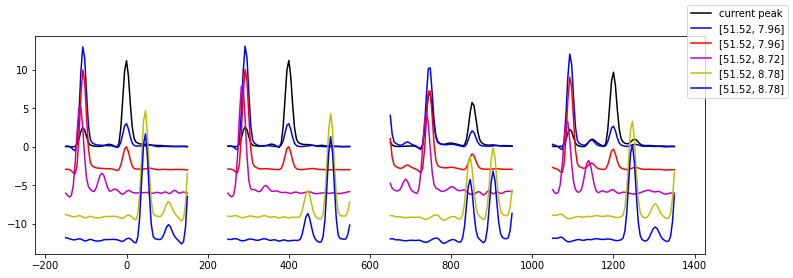

In [3]:
a = int_seq_match(b)#, peak_table_dir = './no_pyruvate/GB1_BCG1.list')
print(tb_nopyr['Assignment'][42])
print(shifts_array[42])
fig = a.find_best_matches(shifts_array[42], gen_plot=True)